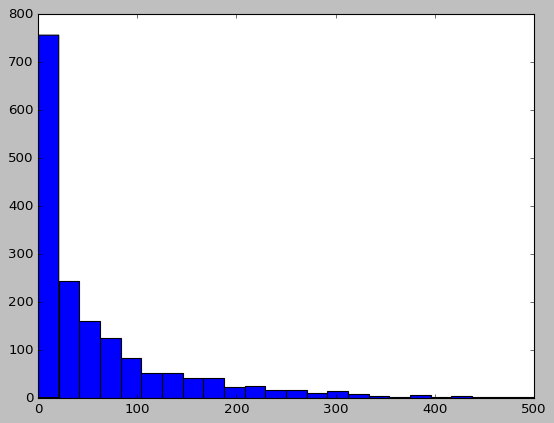

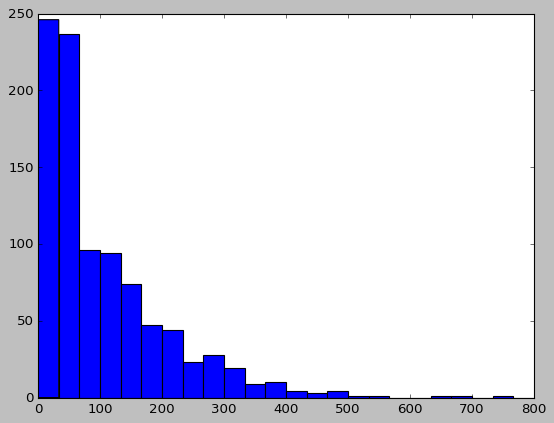

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib.mlab as mlab

fpath = 'u.data'
data = pd.read_csv(fpath,header=None, sep='\t')
df = data

movie_counts = df[1].value_counts().tolist()
user_counts = df[0].value_counts().tolist()
plt.hist(movie_counts, np.linspace(0, 500, 25))
plt.show()
plt.hist(user_counts, np.linspace(0, 800, 25))
plt.show()

In [2]:
import itertools

user_id = data.iloc[:,0]
item_id = data.iloc[:,1]
rating = data.iloc[:,2]


base_path = 'ua.base'
train_data = pd.read_csv(base_path,header=None, sep='\t')
test_path = 'ua.test'
test_data = pd.read_csv(base_path,header=None, sep='\t')
train_data.columns = ['user','movie','rating','timestamp']

users = train_data.iloc[:,0].unique()
movies = item_id.unique()
indices = list(itertools.product(users, movies))
list_of_indices = np.array([list(elem) for elem in indices])
matrix_index = pd.DataFrame(list_of_indices, columns=['user', 'movie'])
# print(matrix_index)
result = pd.merge(matrix_index, train_data, how='outer')
result.fillna(0, inplace=True)

overall_avg = sum(train_data['rating'])/len(train_data['rating'])

lambda2 = 25
lambda3 = 10
only_item_test = list(set(movies) - set(train_data['movie']))
print(only_item_test)
bi_movie = []
train_data_unique_movies = list(set(train_data['movie']))
for movie in train_data_unique_movies:
    all_users_for_movie = train_data[train_data['movie']==movie]
    length_user = 0
    bi_user = []
    for index, row in all_users_for_movie.iterrows():
        if row['rating']==0:
            continue
        else:
            length_user+=1
            bi_user.append(row['rating']-overall_avg)
    bi_movie.append(sum(bi_user)/(lambda2+length_user))
remaining = [0 for i in range(len(only_item_test))]
bi_movie = bi_movie+remaining
total_movies = train_data_unique_movies + only_item_test

bi_score = list(zip(total_movies, bi_movie))
bi_score_list = np.array([list(elem) for elem in bi_score])
bi_score_dict = dict(zip(total_movies, bi_movie))
bi_score_df = pd.DataFrame(bi_score_list, columns=['movie', 'bi_score'])
result_bi = pd.merge(result,bi_score_df,how='outer')
result_bi.fillna(0, inplace=True)
print(result_bi)

[1653, 1582]
         user  movie  rating    timestamp  bi_score
0           1    242     5.0  889751633.0  0.360956
1           2    242     5.0  888552084.0  0.360956
2           3    242     0.0          0.0  0.360956
3           4    242     0.0          0.0  0.360956
4           5    242     0.0          0.0  0.360956
5           6    242     4.0  883268170.0  0.360956
6           7    242     0.0          0.0  0.360956
7           8    242     0.0          0.0  0.360956
8           9    242     4.0  886958715.0  0.360956
9          10    242     0.0          0.0  0.360956
10         11    242     0.0          0.0  0.360956
11         12    242     5.0  879960826.0  0.360956
12         13    242     2.0  881515193.0  0.360956
13         14    242     4.0  876964570.0  0.360956
14         15    242     0.0          0.0  0.360956
15         16    242     0.0          0.0  0.360956
16         17    242     0.0          0.0  0.360956
17         18    242     5.0  880129305.0  0.360956

In [3]:
bu_user = []
for user in users:
    all_movies_for_user = result_bi[result_bi['user']==user]
    length_movie = 0
    bu_movie = []
    for index,row in all_movies_for_user.iterrows():
        if row['rating'] == 0:
            continue
        else:
            length_movie+=1
            bu_movie.append(row['rating']-overall_avg-row['bi_score'])
    bu_user.append(sum(bu_movie)/(lambda3 + length_movie))

test_data.columns = ['user','movie','rating','timestamp']    
bu_score = list(zip(users,bu_user))
bu_score_dict = dict(zip(users,bu_user))
test_len = len(test_data['rating'])- 6536
bu_score_list = np.array([list(elem) for elem in bu_score])
bu_score_df = pd.DataFrame(bu_score_list, columns=['user', 'bu_score'])
result_bi_bu = pd.merge(result_bi,bu_score_df,how='outer')
result_bi_bu.fillna(0, inplace=True)
result_bi_bu['predicted_rating'] = overall_avg + result_bi_bu['bi_score']+result_bi_bu['bu_score']
print(result_bi_bu)

         user  movie  rating    timestamp  bi_score  bu_score  \
0           1    242     5.0  889751633.0  0.360956  0.032686   
1           1    302     0.0          0.0  0.591625  0.032686   
2           1    377     0.0          0.0 -0.382280  0.032686   
3           1     51     4.0  878543275.0 -0.037731  0.032686   
4           1    346     0.0          0.0  0.131028  0.032686   
5           1    474     0.0          0.0  0.644964  0.032686   
6           1    265     0.0          0.0  0.307024  0.032686   
7           1    465     0.0          0.0 -0.017929  0.032686   
8           1    451     0.0          0.0 -0.147659  0.032686   
9           1     86     5.0  878543541.0  0.347134  0.032686   
10          1    257     4.0  874965954.0  0.239762  0.032686   
11          1   1014     0.0          0.0 -0.380116  0.032686   
12          1    222     4.0  878873388.0  0.104691  0.032686   
13          1     40     3.0  876893230.0 -0.444662  0.032686   
14          1     29     

In [4]:
import math 
test_data['predicted_rating'] = [overall_avg+bi_score_dict[test_data['movie'][index]]+bu_score_dict[test_data['user'][index]] for index,x in enumerate(test_data['rating'])]
test_data['RMSE_sq'] = (test_data['rating']-test_data['predicted_rating'])*(test_data['rating']-test_data['predicted_rating'])
RMSE_sum = sum(test_data['RMSE_sq'])
RMSE_score = math.sqrt(RMSE_sum/test_len)
print('RMSE Score',RMSE_score)

RMSE Score 0.9664823070017958


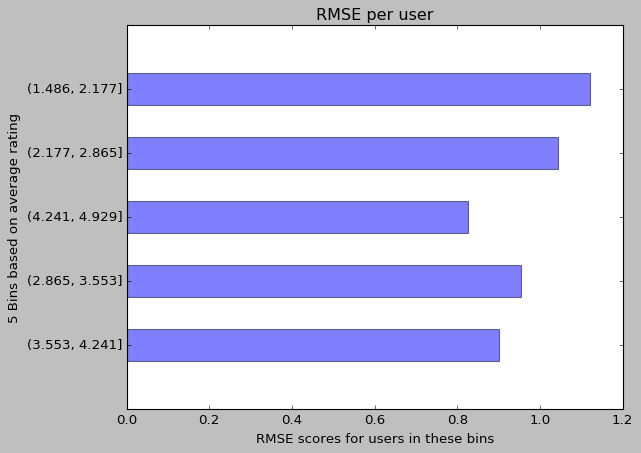

In [5]:
avg_rating_per_user = []
for user in users:
    rating_by_user = train_data[train_data['user']==user]['rating']
    avg_rating = sum(rating_by_user)/len(rating_by_user)
    avg_rating_per_user.append(avg_rating)
avg_user_rating_dict = dict(zip(users,avg_rating_per_user))
avg_rating_range = [min(avg_rating_per_user), max(avg_rating_per_user)]
total_width = avg_rating_range[1] - avg_rating_range[0]
bins = 5
bar_width_range = total_width/bins
# print(avg_rating_range, total_width, bar_width_range)
avg_user_df = pd.DataFrame(
    {'user': users,
     'avg_rating': avg_rating_per_user
    })
test_data = pd.merge(test_data, avg_user_df , how='inner')
test_data['bin'] = pd.cut(test_data['avg_rating'], bins=5)
unique_bins = test_data['bin'].unique()
RMSE_per_bin = []
for u_bin in unique_bins:
    users_per_bin = test_data[test_data['bin']==u_bin]
    RMSE_score = math.sqrt(sum(users_per_bin['RMSE_sq'])/len(users_per_bin))
    RMSE_per_bin.append(RMSE_score)
    

y_pos = np.arange(len(unique_bins)) 
width = 1
plt.barh( y_pos, RMSE_per_bin, .5, align='center',alpha=0.5)
plt.yticks(y_pos,unique_bins)
plt.xlabel('RMSE scores for users in these bins')
plt.ylabel('5 Bins based on average rating')
plt.title('RMSE per user')
plt.show()




In [6]:
from itertools import combinations
import numpy as np

userAvg = {}
uniqueUsers = train_data['user'].unique()
for user in uniqueUsers:
    cols = train_data[train_data['user']==user]
    userAvg[user] = cols['rating'].mean()


uniqueMovies = train_data['movie'].unique()
sM = np.zeros(shape=(len(uniqueMovies),len(uniqueMovies)))
movieMatch = {}
movieUsers = {}
movieUserRatings = {}
count = 0
train_data[train_data['movie']==movie]
for movie in uniqueMovies:
    movieMatch[movie] = count
    movDf = train_data[train_data['movie']==movie]
    movieUsers[movie] = set(movDf['user'])
    mur = {}
    for index, row in movDf.iterrows():  
        mur[row['user']] = row['rating']
    movieUserRatings[movie] = mur
    count +=1
print (len(movieUsers))
for i in range(len(uniqueMovies)):
    mov1 = uniqueMovies[i]
    for j in range(i+1, len(uniqueMovies)):
        mov2 = uniqueMovies[j]
        x = movieMatch[mov1]
        y = movieMatch[mov2]
        intersect = movieUsers[mov1]&movieUsers[mov2]
        mur1 = movieUserRatings[mov1]
        mur2 = movieUserRatings[mov2]
        numer = 0
        denom1 = 0
        denom2 = 0
        for inter in intersect:
            ru1 = mur1[inter] - userAvg[inter]
            ru2 = mur2[inter] - userAvg[inter]
            numer += (ru1*ru2)
            denom1 += (ru1**2)
            denom2 += (ru2**2)
        sim = numer/(np.sqrt(denom1*denom2))
        sM[x][y] = sim
        sM[y][x] = sim
    if not i%100:
        print (i)
print(sM[2][3])
print(sM[3][2])

1680


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in double_scalars


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
-0.368732676627
-0.368732676627


In [8]:
print(len(movies))
print(len(sM[0]))
print(len(sM))

1682
1680
1680


In [30]:
# def find_s_m_score(x):
#     user = x[0]
#     movie = x[1][0]
#     simi_score = x[1][1]
#     r_u =  test_data[test_data['user']==user]
#     r_n = test_data[test_data['movie']==movie]
#     r_u_n = pd.merge(r_u, r_n , how='inner', on=['user','movie','rating','timestamp'])
#     if len(r_u_n):
#         return r_u_n['rating'] * simi_score
#     else:
#         return 0
    
# import heapq
# print('begin')
# pred_k_1 = []
# pred_k_2 = []
# pred_k_3 = []
# pred_k_5 = []
# pred_k_10 = []
# for index,entry in enumerate(test_data.iterrows()):
#     if index%1000==0:
#         print(index)
#     try:
#         seq=sM[(entry[1]['movie']-1)]
#         k_1=heapq.nlargest(1, enumerate(seq), key=lambda x: x[1])
#         k_2=heapq.nlargest(2, enumerate(seq), key=lambda x: x[1])
#         k_3=heapq.nlargest(3, enumerate(seq), key=lambda x: x[1])
#         k_5=heapq.nlargest(5, enumerate(seq), key=lambda x: x[1])
#         k_10=heapq.nlargest(10, enumerate(seq), key=lambda x: x[1])
#         user_list = [entry[1]['user']]*10
#         user_top_10 = list(zip(user_list,k_10))
#         r_u_n_list = list(map(find_s_m_score, user_top_10))
#     except:
#         print(entry[1]['movie'])
    
# print(r_u_n_list)
movieMap = {}
avgRatingsX = []
avgRatingsY = []
mu = train_data['rating'].mean()
for movie in uniqueMovies:
    cols = train_data[train_data['movie']==movie]
    numerator = cols['rating'].sum() - mu*len(cols)
    avgRatingsX.append([movie])
    avgRatingsY.append(cols['rating'].mean())
    denom = lambda2 + len(cols)
    movieMap[movie] = numerator/denom
    
userMap = {}
uniqueUsers = train_data['user'].unique()
for user in uniqueUsers:
    cols = train_data[train_data['user']==user]
    bi = 0
    for movie in cols['movie']:
        bi += movieMap[movie]
    numerator = cols['rating'].sum() - mu*len(cols) - bi
    denom = lambda3 + len(cols)
    userMap[user] = numerator/denom

movTest = test_data['movie'].unique()
Xtest = []
ytest = []
for movie in movTest:
    cols = test_data[test_data['movie']==movie]
    Xtest.append([movie])
    ytest.append(cols['rating'].mean())
    
movieSet = set(uniqueMovies)
import sklearn
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KNeighborsRegressor

def mydist(mov1, mov2):
    if mov1[0] in movieSet and mov2[0] in movieSet:
        x = movieMatch[mov1[0]]
        y = movieMatch[mov2[0]]
        return sM[x][y]
    return mu

k = [1,2,3,5,10]

rms_k = []

knn = KNeighborsRegressor(n_neighbors=1,algorithm='brute', metric=mydist, n_jobs=-1)
knn.fit(avgRatingsX, avgRatingsY)
predY = knn.predict(Xtest)
score = (predY == ytest).sum()/len(predY)

new_predY_1 = [0 for i in movies]
new_predY_1[:1581] = predY[:1581]
new_predY_1[1582:1652] = predY[1581:1651]
new_predY_1[1652] = overall_avg
new_predY_1[1581] = overall_avg
new_predY_1[1653:] = predY[1651:]

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(ytest, predY))
rms_k.append(rms)
print (rms)
knn = KNeighborsRegressor(n_neighbors=2,algorithm='brute', metric=mydist, n_jobs=-1)
knn.fit(avgRatingsX, avgRatingsY)
predY = knn.predict(Xtest)
score = (predY == ytest).sum()/len(predY)

new_predY_2 = [0 for i in movies]
new_predY_2[:1581] = predY[:1581]
new_predY_2[1582:1652] = predY[1581:1651]
new_predY_2[1652] = overall_avg
new_predY_2[1581] = overall_avg
new_predY_2[1653:] = predY[1651:]

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(ytest, predY))
rms_k.append(rms)
print (rms)

knn = KNeighborsRegressor(n_neighbors=3,algorithm='brute', metric=mydist, n_jobs=-1)
knn.fit(avgRatingsX, avgRatingsY)
predY = knn.predict(Xtest)
score = (predY == ytest).sum()/len(predY)

new_predY_3 = [0 for i in movies]
new_predY_3[:1581] = predY[:1581]
new_predY_3[1582:1652] = predY[1581:1651]
new_predY_3[1652] = overall_avg
new_predY_3[1581] = overall_avg
new_predY_3[1653:] = predY[1651:]

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(ytest, predY))
rms_k.append(rms)
print (rms)

knn = KNeighborsRegressor(n_neighbors=5,algorithm='brute', metric=mydist, n_jobs=-1)
knn.fit(avgRatingsX, avgRatingsY)
predY = knn.predict(Xtest)
score = (predY == ytest).sum()/len(predY)

new_predY_5 = [0 for i in movies]
new_predY_5[:1581] = predY[:1581]
new_predY_5[1582:1652] = predY[1581:1651]
new_predY_5[1652] = overall_avg
new_predY_5[1581] = overall_avg
new_predY_5[1653:] = predY[1651:]

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(ytest, predY))
rms_k.append(rms)
print (rms)

knn = KNeighborsRegressor(n_neighbors=10,algorithm='brute', metric=mydist, n_jobs=-1)
knn.fit(avgRatingsX, avgRatingsY)
predY = knn.predict(Xtest)
score = (predY == ytest).sum()/len(predY)


from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(ytest, predY))
rms_k.append(rms)
print (rms)

1.2288102470032716
1.169757112707372
1.1491524988586608
1.074066460524835
1.0741641600810463


In [31]:
print(len(train_data))
print(len(predY))
print(len(ytest))

90570
1680
1680


In [32]:
print(set(movies)-set(uniqueMovies))

{1653, 1582}


In [34]:
new_predY_10 = [0 for i in movies]
new_predY_10[:1581] = predY[:1581]
new_predY_10[1582:1652] = predY[1581:1651]
new_predY_10[1652] = overall_avg
new_predY_10[1581] = overall_avg
new_predY_10[1653:] = predY[1651:]
pred_df = pd.DataFrame({'movie' : movies,
    'pred_1' : new_predY_1,
    'pred_2' : new_predY_2,
    'pred_3' : new_predY_3,
    'pred_5' : new_predY_5,
    'pred_10' : new_predY_10
  }, columns=['movie','pred_1', 'pred_2','pred_3','pred_5','pred_10'])
print(pred_df)

      movie    pred_1    pred_2    pred_3    pred_5   pred_10
0       242  2.666667  3.333333  3.555556  3.200000  3.233333
1       302  2.000000  3.125000  3.166667  3.173333  2.836667
2       377  3.700000  3.665789  3.443860  3.626316  3.004825
3        51  2.666667  2.666667  2.444444  2.766667  2.083333
4       346  3.105263  2.885965  2.257310  2.621053  3.103860
5       474  3.222222  3.055556  3.272331  3.189486  3.089160
6       265  4.714286  4.357143  4.238095  3.476190  2.554762
7       465  3.250000  3.375000  2.850000  2.810000  2.180000
8       451  2.666667  2.690476  2.960317  2.600000  2.598095
9        86  3.391304  3.295652  3.197101  2.646466  2.664900
10      257  4.250000  3.125000  3.416667  3.050000  2.291667
11     1014  2.500000  3.250000  3.500000  2.900000  2.816667
12      222  3.000000  2.833333  2.777778  3.219048  3.276190
13       40  2.666667  2.333333  2.305556  3.183333  2.751667
14       29  2.666667  2.233333  2.488889  2.493333  2.846667
15      

In [35]:
print(test_data)

       user  movie  rating  timestamp  predicted_rating   RMSE_sq  avg_rating  \
0         1      1       5  874965758          3.872244  1.271833    3.603053   
1         1      2       3  876893171          3.286766  0.082235    3.603053   
2         1      3       4  878542960          3.197193  0.644500    3.603053   
3         1      4       3  876893119          3.575716  0.331449    3.603053   
4         1      5       3  889751712          3.379760  0.144218    3.603053   
5         1      6       5  887431973          3.513846  2.208653    3.603053   
6         1      7       4  875071561          3.817311  0.033375    3.603053   
7         1      8       1  875072484          4.001160  9.006960    3.603053   
8         1      9       5  878543541          3.879429  1.255679    3.603053   
9         1     10       3  875693118          3.790590  0.625032    3.603053   
10        1     11       2  875072262          3.805809  3.260946    3.603053   
11        1     12       5  

In [36]:
final_test_data = pd.merge(test_data, pred_df, how = 'inner')
print(final_test_data)

       user  movie  rating  timestamp  predicted_rating   RMSE_sq  avg_rating  \
0         1      1       5  874965758          3.872244  1.271833    3.603053   
1         2      1       4  888550871          3.925964  0.005481    3.750000   
2         6      1       4  883599478          3.691889  0.094933    3.631841   
3        10      1       4  877888877          4.246013  0.060522    4.201149   
4        13      1       3  882140487          3.471022  0.221862    3.089457   
5        15      1       1  879455635          3.410501  5.810516    2.957447   
6        16      1       5  877717833          4.439609  0.314038    4.330769   
7        18      1       5  880130802          3.972469  1.055820    3.880150   
8        20      1       3  879667963          3.505529  0.255560    3.210526   
9        21      1       5  874951244          3.282273  2.950585    2.656805   
10       23      1       5  874784615          3.783533  1.479792    3.638298   
11       25      1       5  

plot for k=1


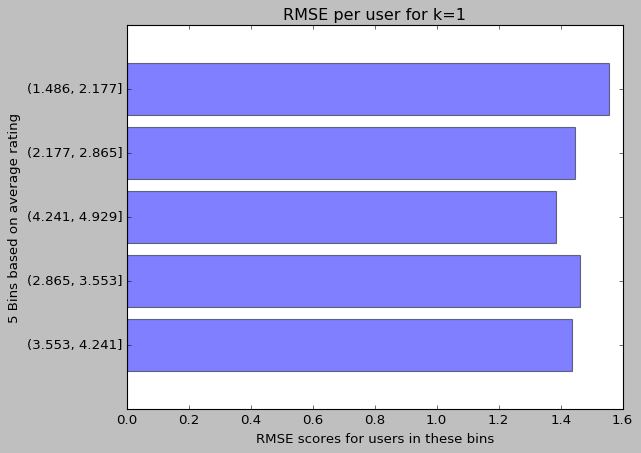

plot for k=2


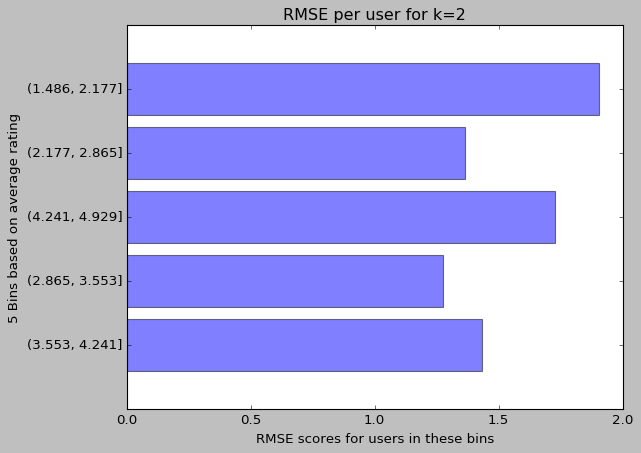

plot for k=3


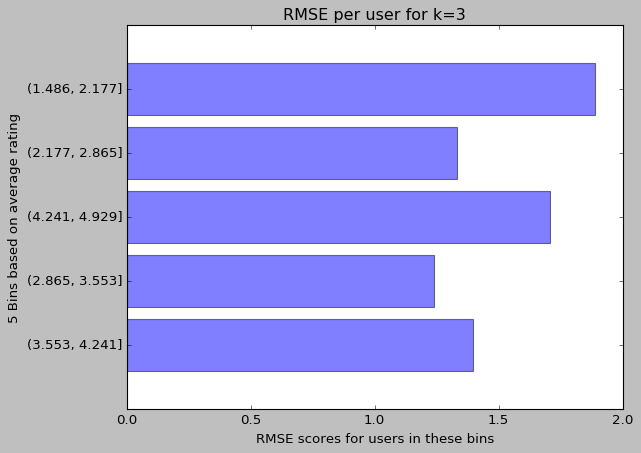

plot for k=5


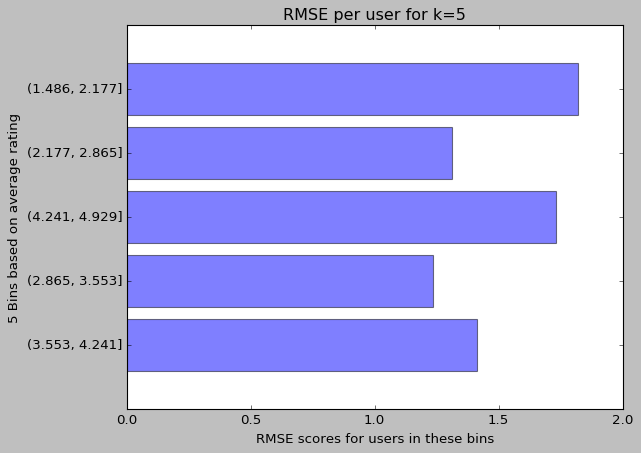

plot for k=10


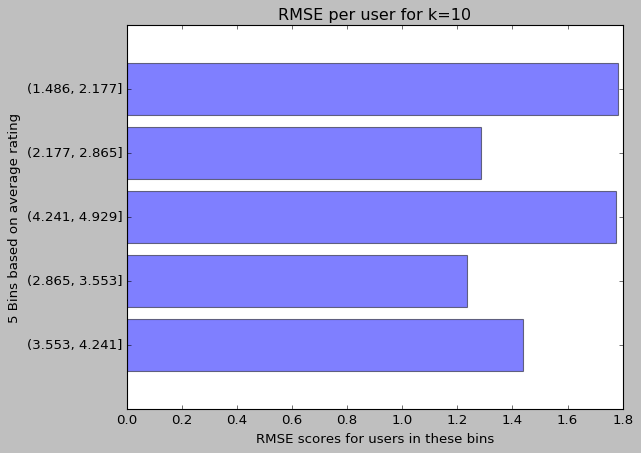

In [46]:
RMSE_per_bin_1 = []
print('plot for k=1')
for u_bin in unique_bins:
    users_per_bin = final_test_data[test_data['bin']==u_bin]
    c = (users_per_bin['rating']-users_per_bin['pred_1']) * (users_per_bin['rating']-users_per_bin['pred_1'])
    RMSE_score = math.sqrt(sum(c)/len(users_per_bin))
    RMSE_per_bin_1.append(RMSE_score)
    
y_pos = np.arange(len(unique_bins)) 

plt.barh( y_pos, RMSE_per_bin_1, align='center',alpha=0.5)
plt.yticks(y_pos,unique_bins)
plt.xlabel('RMSE scores for users in these bins')
plt.ylabel('5 Bins based on average rating')
plt.title('RMSE per user for k=1')
plt.show()

RMSE_per_bin_2 = []
print('plot for k=2')
for u_bin in unique_bins:
    users_per_bin = final_test_data[final_test_data['bin']==u_bin]
    c = (users_per_bin['rating']-users_per_bin['pred_2']) * (users_per_bin['rating']-users_per_bin['pred_2'])
    RMSE_score = math.sqrt(sum(c)/len(users_per_bin))
    RMSE_per_bin_2.append(RMSE_score)
    
plt.barh( y_pos, RMSE_per_bin_2, align='center',alpha=0.5)
plt.yticks(y_pos,unique_bins)
plt.xlabel('RMSE scores for users in these bins')
plt.ylabel('5 Bins based on average rating')
plt.title('RMSE per user for k=2')
plt.show()

RMSE_per_bin_3 = []
print('plot for k=3')
for u_bin in unique_bins:
    users_per_bin = final_test_data[final_test_data['bin']==u_bin]
    c = (users_per_bin['rating']-users_per_bin['pred_3']) * (users_per_bin['rating']-users_per_bin['pred_3'])
    RMSE_score = math.sqrt(sum(c)/len(users_per_bin))
    RMSE_per_bin_3.append(RMSE_score)
    
plt.barh( y_pos, RMSE_per_bin_3, align='center',alpha=0.5)
plt.yticks(y_pos,unique_bins)
plt.xlabel('RMSE scores for users in these bins')
plt.ylabel('5 Bins based on average rating')
plt.title('RMSE per user for k=3')
plt.show()

RMSE_per_bin_5 = []
print('plot for k=5')
for u_bin in unique_bins:
    users_per_bin = final_test_data[final_test_data['bin']==u_bin]
    c = (users_per_bin['rating']-users_per_bin['pred_5']) * (users_per_bin['rating']-users_per_bin['pred_5'])
    RMSE_score = math.sqrt(sum(c)/len(users_per_bin))
    RMSE_per_bin_5.append(RMSE_score)
    
plt.barh( y_pos, RMSE_per_bin_5, align='center',alpha=0.5)
plt.yticks(y_pos,unique_bins)
plt.xlabel('RMSE scores for users in these bins')
plt.ylabel('5 Bins based on average rating')
plt.title('RMSE per user for k=5')
plt.show()

RMSE_per_bin_10 = []
print('plot for k=10')
for u_bin in unique_bins:
    users_per_bin = final_test_data[final_test_data['bin']==u_bin]
    c = (users_per_bin['rating']-users_per_bin['pred_10']) * (users_per_bin['rating']-users_per_bin['pred_10'])
    RMSE_score = math.sqrt(sum(c)/len(users_per_bin))
    RMSE_per_bin_10.append(RMSE_score)
    
plt.barh( y_pos, RMSE_per_bin_10, align='center',alpha=0.5)
plt.yticks(y_pos,unique_bins)
plt.xlabel('RMSE scores for users in these bins')
plt.ylabel('5 Bins based on average rating')
plt.title('RMSE per user for k=10')
plt.show()